# **Soni - do**
## **Generating Music with Machine Learning**


#### Author: Sonia Cobo
#### Date: July 2021

### Though this project doesn't have a hypothesis per se, it was done to kind off prove how AI has advanced and it is now able to generate music which has been associated with emotions and human capabilities for a long period of time.

In [2]:
# data augmentation - dividir canciones, modificarlas para tener mas datos

# Data

### The input to the model will be a series of notes from a MIDI file. MIDI (Musical Instrument Digital Interface) is a technical standard that describes a communications protocol, digital interface, and electrical connectors that connect a wide variety of electronic musical instruments and computers. They don't contain actual audio data and are small in size. They explain what notes are played, when they're played, and how long or loud each note should be.

### To keep the project simple only files with one instrument were chosen, in this case the instrument is piano and the type of songs is classical. 
### These songs have been obtained from the following datasets: http://www.piano-midi.de/ and https://www.mfiles.co.uk/classical-midi.htm


In [3]:
# no descargardas aun: https://github.com/Skuldur/Classical-Piano-Composer/tree/master/midi_songs
# https://drive.google.com/file/d/1qnQVK17DNVkU19MgVA4Vg88zRDvwCRXw/view

### Import all libraries

In [4]:
# data manipulation
import numpy as np
import pandas as pd 

# manipulate midi files
import glob
from music21 import converter, instrument, note, chord, meter, stream, duration, corpus
import pygame

# visualization
import seaborn as sns
import matplotlib.pyplot as plt

# route files
import os
import sys

# ml model
import pickle

import tensorflow as tf
from tensorflow import keras

from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.callbacks import ModelCheckpoint
from keras.layers import Bidirectional


pygame 2.0.1 (SDL 2.0.14, Python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


In [5]:
len(tf.config.experimental.list_physical_devices('GPU'))

0

In [6]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 3608581324200734813
]


### Paths

In [7]:
# The route of this file is added to the sys path to be able to import/export functions
sep = os.sep
def route (steps):
    """
    This function appends the route of the file to the sys path
    to be able to import files from/to other foders within the EDA project folder.
    """
    route = os.getcwd()
    for i in range(steps):
        route = os.path.dirname(route)
    sys.path.append(route)
    return route

In [8]:
# path to data folder
path = route(1) + sep + "data" + sep + "raw_data" + sep
path_1 = route(1) + sep + "data" + sep + "converted_data" + sep
path_2 = route(1) + sep + "data" + sep + "notes" + sep
path_3 = route(1) + sep + "models" + sep

## Midi file exploration

Hablar de frecuencia y la transpuesta de fourier

In [9]:
from scipy.io import wavfile 
from matplotlib import pyplot as plt 
import numpy as np 

samplerate, data = wavfile.read("first_test_output.mid")    # research this
times = np.arange(len(data))/float(samplerate)

#plt.plot(data[:1000])

ValueError: File format b'MThd' not understood. Only 'RIFF' and 'RIFX' supported.

In [ ]:
def play_music(music_file):
    """
    Play music given a midi file path
    """
    try:
        # allow to stop the piece 
        clock = pygame.time.Clock() 
        pygame.mixer.music.load(music_file)
        pygame.mixer.music.play()
        while pygame.mixer.music.get_busy():
            # check if playback has finished
            clock.tick(10)

        freq = 44100    # audio CD quality
        bitsize = -16   # unsigned 16 bit
        channels = 2    # 1 is mono, 2 is stereo
        buffer = 1024    # number of samples
        pygame.mixer.init(freq, bitsize, channels, buffer)

    except KeyboardInterrupt:
        while True:
            action = input('Enter Q to Quit, Enter to Skip. ').lower()
            if action == 'q':
                pygame.mixer.music.fadeout(1000)
                pygame.mixer.music.stop()
            else:
                break

In [ ]:
# It plays when the cell is executed

play_music(path + "alb_esp2.mid")

In [ ]:
file = converter.parse(path + "alb_esp1.mid")
#file.show("text")  # left-side numbers represent the offset

In [ ]:
#clarificar a que se refieren con offset vs frecuencia vs pitches

In [11]:
# All information from the midi file (i.e. notes, pitch, chord, time signature, etc) is contained within the component list
def info_midi (path):
    """
    It returns all midi file information given its path

    """
    file = converter.parse(path)
    components = []
    for element in file.recurse():  
        components.append(element)
    return components

components = info_midi(path + "alb_esp1.mid")
#components

In [ ]:
# Objects stored in a Stream are generally spaced in time; each stored object has an offset usually representing how many quarter notes 
# lies from the beginning of the Stream. For instance in a 4/4 measure of two half notes, the first note will be at offset 0.0,  
# and the second at offset 2.0.

In [121]:
# The time signature will be 4/4 to simplify the process and to be able generate a pattern that sounds like actual music. 
# A time signature of 4/4 meant 8 different sequence of 4 notes.

for element in components:
    if isinstance(element, meter.TimeSignature):
        print(element)

# no se cambiar el tiempo

<music21.meter.TimeSignature 3/4>
<music21.meter.TimeSignature 3/4>


In [31]:
# offsets will be considered as seen before.........do something about it later

### Now that the midi file has been studied and its structure is known, data will be split into two object types: notes, rests and chords. 

### Note objects contain information about the pitch, octave, and offset of the note.
### Pitch refers to the frequency of the sound, or how high or low it is and is represented with the letters [A, B, C, D, E, F, G].
### Octave refers to which set of pitches you use on a piano.
### Offset refers to where the note is located in the piece.
### Rests are the silences in the piece.
### Chord objects are a set of notes that are played at the same time.


### Songs are transposed into C major and A minor key to ease predictions

In [92]:
path

'c:\\Users\\Usuario\\Desktop\\The_Bridge\\ML_Project\\data\\raw_data\\'

In [86]:
#converts all MIDI files in the current folder into the key of C major or A minor to restrict the key
def convert_to_midi(ruta, ruta_1):
    import music21
    # major conversions
    majors = dict([("A-", 4),("G#", 4),("A", 3),("A#", 2),("B-", 2),("B", 1),("C", 0),("C#", -1),("D-", -1),("D", -2),("D#", -3),("E-", -3),("E", -4),("F", -5),("F#", 6),("G-", 6),("G", 5)])
    minors = dict([("G#", 1), ("A-", 1),("A", 0),("A#", -1),("B-", -1),("B", -2),("C", -3),("C#", -4),("D-", -4),("D", -5),("D#", 6),("E-", 6),("E", 5),("F", 4),("F#", 3),("G-", 3),("G", 2)])       

    # MIDI songs path
    #path = route(1) + sep + "data" + sep + "raw_data" + sep
    #path_1 = route(1) + sep + "data" + sep + "converted_data" + sep
    # os.chdir("./")
    for file in glob.glob(path + "*.mid"):
        score = music21.converter.parse(file)
        key = score.analyze('key')
        
    # print key.tonic.name, key.mode
        if key.mode == "major":
            halfSteps = majors[key.tonic.name]
            
        elif key.mode == "minor":
            halfSteps = minors[key.tonic.name]
        
        newscore = score.transpose(halfSteps)
        key = newscore.analyze("key")
        #print(key.tonic.name, key.mode)
        newFileName = "C_" + file[50:]
        newscore.write("midi", path_1 + newFileName)

convert_to_midi(path, path_1)

FileNotFoundError: [Errno 2] No such file or directory: 'c:\\Users\\Usuario\\Desktop\\The_Bridge\\ML_Project\\data\\converted_data\\C_a\\raw_data\\alb_esp1.mid'

In [141]:
# info_midi(path_1 + "C_alb_esp1.mid")   -chequeado que funciona, enseñarlo???

## Data preparation

### Relevant information from midi file is encoded and saved into an array.

### We append the pitch of every note object using its string notation since the most significant parts of the note can be recreated using the string notation of the pitch. And we append every chord by encoding the id of every note in the chord together into a single string, with each note being separated by a dot. 

In [129]:
# Each midi file contains notes and chords. These two properties will be the input and output of the LSTM network so 
# they need to be taken out from all midi files. 

def get_notes_per_song(path, filename):
    """
    This function extracts all the notes, rests and chords from one midi file
    and saves it in a list in the converted_data folder.

    Param: Path of the midi file, filename (str)
    """
    components = info_midi(path + filename)
    note_list = []
    
    for element in components:
        # note pitches are extracted
        if isinstance(element, note.Note):
            note_list.append(str(element.pitch))
        # chords are extracted
        elif isinstance(element, chord.Chord):
            note_list.append(".".join(str(n) for n in element.normalOrder))    
        # rests are extracted
        elif isinstance(element, note.Rest):
            note_list.append("NULL")    #further transformation needs this value as str rather than np.nan

    with open(path_2 + "notes", "wb") as filepath:
        pickle.dump(note_list, filepath)
    
    return (note_list)

In [130]:
one = get_notes_per_song(path_1, "C_alb_esp1.mid")

In [133]:
# generate dataframe

def create_dataframe(path=path_1):
    """
    el dataframe ya me convierte las canciones también
    """
    list_path = os.listdir(path)
    piece_list = []
    notes = []
    for elem in list_path:
        output = get_notes_per_song(path, elem)
        piece_list.append(elem[:-4])
        notes.append(output)

    df = pd.DataFrame.from_dict({"Piece":piece_list, "Notes":notes}, orient="index")
    df = df.transpose()
    return df

df = create_dataframe()
df

,Piece,Notes
0,C_alb_esp1,"[NULL, E5, B5, A5, A5, G5, A5, B5, C6, D6, B5,..."
1,C_alb_esp2,"[NULL, G3, 0.4.7, NULL, G3, 0.4.7, 7.0, E4, F4..."
2,C_alb_esp3,"[E5, NULL, G#5, NULL, B5, NULL, A5, A5, F5, NU..."
3,C_alb_esp4,"[A5, NULL, E5, NULL, F5, NULL, A5, NULL, G#5, ..."
4,C_alb_esp5,"[NULL, 0.4, 11.2, 2.5, 11.2, 0.4, 9.0, 5.9, 4...."
5,C_alb_esp6,"[NULL, 1.4, 2.5, 2.5, 9.0, 7.11, 11.3, 0.4, 4...."
6,C_alb_se1,"[NULL, 7.0, NULL, 0.4.7, 0.4.7, NULL, 4.7, 0.4..."


In [134]:
# Represent all different notes in one song-------------------
# ------------------------------------in streamlit let user choose the song, o hacer las gráficas en streamlit para que sean interactivas

def plot_one_song(number):
    """
    Plot all different notes and rests contained in one song
    """
    clean_column = df["Notes"][number]
    contador = 0
    while contador <= len(clean_column):
        contador +=1
        for elem in clean_column:
            if elem.count(".") >= 1 or elem == "NULL" or elem.isdigit() == True:
                clean_column.remove(elem)

    fig, ax = plt.subplots(figsize=(8, 4))

    piece_title= df["Piece"][number]
    sns.histplot(clean_column, color = "green", label=f"Piece title: {piece_title[2:]}")

    ax.set_xlabel("Notes")
    ax.legend(loc="best")
    plt.xticks(rotation = 90)

    plt.show()


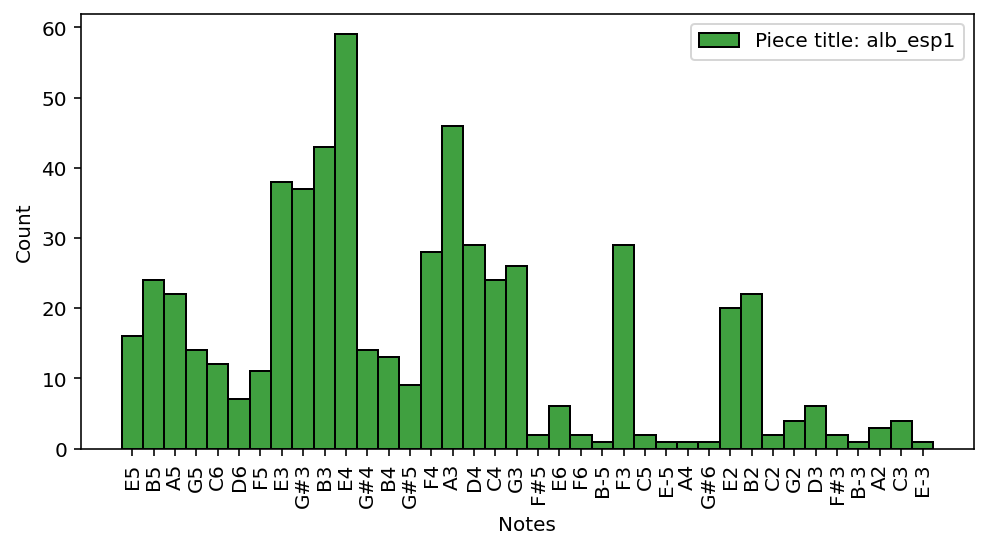

In [135]:
plot_one_song(0)            # ordenarlo de mayor a menor?????????????, cambiar el color???????????????

In [136]:
# Represent all different notes in all songs

def plot_all_songs():
    """
    Plot all different notes and rests contained in one song
    """
    fig, ax = plt.subplots(figsize=(8, 4))

    # copy of note_list to not delete info for the model
    clean_list = note_list[::]
    contador = 0
    while contador <= len(clean_list):
        contador +=1
        for elem in clean_list:
            # remove chords and rests
            if elem.count(".") >= 1 or elem == "NULL" or elem.isdigit() == True:
                clean_list.remove(elem)

    sns.histplot(clean_list, color = "green")

    ax.set_xlabel("Notes")
    plt.xticks(rotation = 90)

    plt.show()

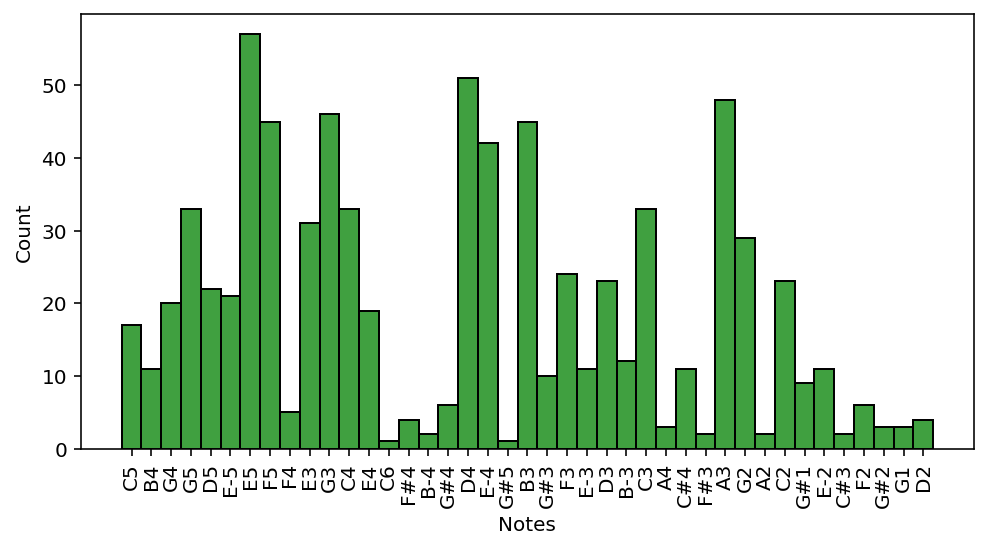

In [137]:
plot_all_songs()

In [ ]:
# more data analysis---------------------------------------------------------------------------

In [138]:
# Save cleaned data in the appropriate folder, in this case it is the folder 'data'
def save_dataframe(dataframe, dataframe_name, steps):
    """
    This function creates csv files with the cleaned data.
    Param: Dataframe to save, dataframe name as string to save the data with that name
    """
    dataframe.reset_index(inplace = True)
    if "index" in dataframe.columns:
        dataframe.drop(columns = "index", inplace = True)
    dataframe.to_csv(route(steps) + os.sep + "data" + os.sep + "output" + os.sep + dataframe_name + ".csv", index=False)
    return "Your file has been saved"

In [139]:
df = save_dataframe(df, "df_music", 1)
df

'Your file has been saved'

In [140]:
# Load notes and chords previously separated
def load_notes (path, filename):
    """
    Load the note list containing pitches, rests and chords.
    
    Param: Path of the saved note list, and its name as string
    """
    with open(path + filename, "rb") as f:
        loaded_notes = pickle.load(f)
        return loaded_notes

loaded_notes = load_notes(path_2, "notes")
#loaded_notes

### The model will be first trained with a small proportioned of the songs to expedite time. Once the model is tunned properly all songs will be passed to improve its training.

In [234]:
#No. of unique notes
unique_notes = list(set(loaded_notes))
print(f"There are {len(unique_notes)} unique notes")

There are 73 unique notes


### Now that all notes, rests and chords are in a list, these will be transformed from categorical data to integer-based numerical data. It is necessary to create input sequences for the network and their respective outputs. The output for each input sequence will be the first note or chord that comes after the sequence of notes in the input sequence in our list of notes.

In [87]:
# new_items = [0 for x in loaded_notes if x == "NULL" ]


In [150]:
def prepare_sequences(notes, sequence_length, step):
    """ 
    Prepare the sequences used by the neural network 

    """
    # get all pitch names except rests
    #pitchnames = sorted(set(item for item in notes if item != "NULL"))
    
    # get all pitch names
    #pitchnames = sorted(set(item for item in notes)) 
    pitchnames = sorted(set(notes))

    # create a dictionary to convert pitches (strings) to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
    # (rests are included)   

    network_input = []
    network_output = []

    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, step):    
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        # exchange their values for their integer-code
        network_input.append([note_to_int[elem] for elem in sequence_in])
        network_output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    network_input = np.reshape(network_input, (n_patterns, sequence_length, 1)) 
    # normalize input
    network_input = network_input / float(len(set(notes)))  

    network_output = np_utils.to_categorical(network_output) # used to convert array of labeled data to one-hot vector

    return (network_input, network_output)

### The length of each sequence will be 100 notes/chords for now. This means that to predict the next note in the sequence the network has the previous 100 notes to help make the prediction

In [151]:
network_input, network_output = prepare_sequences(notes=loaded_notes, sequence_length=100, step=3)  # length y step pueden variar  


In [152]:
print(network_input.shape)
print(network_output.shape)

(457, 100, 1)
(457, 73)


In [153]:
network_input.shape[1], network_input.shape[2]

(100, 1)

# Creation of the model

There are four different types of layers:

LSTM layers is a Recurrent Neural Net layer that takes a sequence as an input and can return either sequences (return_sequences=True) or a matrix.

Dropout layers are a regularisation technique that consists of setting a fraction of input units to 0 at each update during the training to prevent overfitting. The fraction is determined by the parameter used with the layer.

Dense layers or fully connected layers is a fully connected neural network layer where each input node is connected to each output node.

The Activation layer determines what activation function our neural network will use to calculate the output of a node.

In [156]:
def create_network():
    n_vocab = len(set(loaded_notes))

    model = Sequential()
    model.add(LSTM(512,    # igualar los nodos a len(unique_notes)?
        input_shape=(network_input.shape[1], network_input.shape[2]),
        recurrent_dropout=0.3,
        return_sequences=True))
    model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
    model.add(Dense(n_vocab))
    model.add(Activation("softmax"))
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop")

    return model

In [157]:
model.fit(network_input, network_output, epochs=10)#, batch_size=128)

Epoch 1/10
15/15 [==============================] - 44s 3s/step - loss: 3.7099
Epoch 2/10
15/15 [==============================] - 45s 3s/step - loss: 3.6077
Epoch 3/10
15/15 [==============================] - 45s 3s/step - loss: 3.8886
Epoch 4/10
15/15 [==============================] - 44s 3s/step - loss: 3.8855
Epoch 5/10
15/15 [==============================] - 45s 3s/step - loss: 3.7284
Epoch 6/10
15/15 [==============================] - 45s 3s/step - loss: 3.5888
Epoch 7/10
15/15 [==============================] - 45s 3s/step - loss: 3.5321
Epoch 8/10
15/15 [==============================] - 45s 3s/step - loss: 3.9064
Epoch 9/10
15/15 [==============================] - 44s 3s/step - loss: 3.6630
Epoch 10/10
15/15 [==============================] - 44s 3s/step - loss: 3.4186


In [158]:
# save the model
model.save(path_3 + "model_3.h5")

In [159]:
# load the model 
model_3 = tf.keras.models.load_model(path_3 + "model_3.h5")


In [212]:
print(len(loaded_notes))
print(network_input.shape)

1469
(457, 100, 1)


In [243]:
network_input[start].shape

(100, 1)

In [304]:
n_vocab = len(set(loaded_notes))

#start = np.random.randint(0, len(network_input)-1)  #restar seq len?

pitchnames = sorted(list(set(loaded_notes)))   
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

#pattern = network_input[start]
prediction_output = []
pattern_list = []

# generate 500 notes, roughly two minutes of music
for note_index in range(10):
    start = np.random.randint(0, len(network_input)-1)  #restar seq len?

    pattern = network_input[start]
    pattern_list.append(pattern)
    
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    # normalize
    #prediction_input = prediction_input / float(n_vocab)

    prediction = model.predict(prediction_input, verbose=0)

    # Returns the indices of the maximum values along an axis
    index = np.argmax(prediction)
    result = int_to_note[index] 
    prediction_output.append(result)

    patterns.append(index)
    pattern = pattern[1:len(pattern)]

4

In [283]:
def sample(preds, temperature=1.0):
    # helper function to sample an index from a probability array
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return preds

In [281]:
def generate_notes(model, network_input, n_vocab, notes):
    """ 
    Generate notes from the neural network based on a sequence of notes 
    """
    # pick a random sequence from the input as a starting point for the prediction
    start = np.random.randint(0, len(network_input)-1)

    pitchnames = sorted(set(item for item in notes))   
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))

    pattern = network_input[start]
    prediction_output = []
    patterns
    # generate 500 notes, roughly two minutes of music
    for note_index in range(10):
        prediction_input = np.reshape(pattern, (1, len(pattern), 1))
        # normalize
        prediction_input = prediction_input / float(n_vocab)

        prediction = model.predict(prediction_input, verbose=0)

        # Returns the indices of the maximum values along an axis
        index = sample(prediction, temperature = 0.2)
        result = int_to_note[index] 
        prediction_output.append(result)

        patterns.append(index)
        #pattern = pattern[1:len(pattern)]

    return prediction_output, pattern, prediction

In [282]:
n_vocab = len(set(loaded_notes))
prediction_output, pattern, prediction = generate_notes(model_2, network_input, n_vocab, loaded_notes)
print(prediction_output)


ValueError: object too deep for desired array

In [170]:
int_to_note[39]

'C#4'

In [163]:
# si puedo saber la nota que predice con este output

# Output

In [47]:
def create_midi(prediction_output, pattern):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
        offset += 0.5

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp='test_output_4.mid')   # first output 01/07/2021

    return midi_stream

In [48]:
create_midi = create_midi(prediction_output, pattern)


In [ ]:
# lo de abajo aun no lo he utilizado para producir ningun midi

In [76]:
def prepare_sequences_out(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 100
    network_input = []
    output = []
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        sequence_out = notes[i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])
        output.append(note_to_int[sequence_out])

    n_patterns = len(network_input)

    # reshape the input into a format compatible with LSTM layers
    normalized_input = np.reshape(network_input, (n_patterns, sequence_length, 1))
    # normalize input
    normalized_input = normalized_input / float(n_vocab)

    return (network_input, normalized_input)

In [91]:
# esta celda no funciona, creo el output desde la funcion create midi

# Get all pitch names
pitchnames = sorted(set(item for item in notes))
# Get all pitch names
n_vocab = len(set(notes))

network_input, normalized_input = prepare_sequences_out(notes, pitchnames, n_vocab)
prediction_output, pattern = generate_notes(model, network_input, n_vocab, loaded_notes)
create_midi(prediction_output)

TypeError: 'Stream' object is not callable

In [89]:
# no la uso aun - lo saque fuera de la funcion arriva
def generate():
    """ Generate a piano midi file """

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input, normalized_input = prepare_sequences_out(notes, pitchnames, n_vocab)
    model = create_network()
    prediction_output, pattern = generate_notes(model, network_input, n_vocab, loaded_notes)
    create_midi(prediction_output)

In [ ]:
# GAN
# red neuronal que conoce los sonidos
# red que predice tb recursiva

In [ ]:
# Read h5 format files 
import h5py
filename = "test.h5"

with h5py.File(filename, "r") as f:
    # List all groups
    print("Keys: %s" % f.keys())
    a_group_key = list(f.keys())[0]

    # Get the data
    data = list(f[a_group_key])